In [1]:
import pandas as pd
from intertrans.data import read_engine_output
import itertools
import numpy as np
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
pd.options.display.precision = 2

## RQ3: How could varying the selection of intermediate languages affect INTERTRANS?

In [2]:
df_codellama_13b_transcoder_noverify = read_engine_output('../data/raw_outputs/engine/noverify/codellama_13b_transcoder_results_all_depth4.json')
df_magicoder_transcoder_noverify = read_engine_output('../data/raw_outputs/engine/noverify/magicoder_transcoder_results_all_depth4.json')
df_starcoder2_transcoder_noverify = read_engine_output('../data/raw_outputs/engine/noverify/starcoder2_transcoder_results_all_depth4.json')

df_codellama_13b_humanevalx_noverify = read_engine_output('../data/raw_outputs/engine/noverify/codellama_13b_humanevalx_results_sub_depth4.json')
df_magicoder_humanevalx_noverify = read_engine_output('../data/raw_outputs/engine/noverify/magicoder_humanevalx_results_sub_depth4.json')
df_starcoder2_humanevalx_noverify = read_engine_output('../data/raw_outputs/engine/noverify/starcoder2_humanevalx_results_sub_depth4.json')

df_codellama_13b_codenet_noverify = read_engine_output('../data/raw_outputs/engine/noverify/codellama_13b_codenet_results_sub_depth4.json')
df_magicoder_codenet_noverify = read_engine_output('../data/raw_outputs/engine/noverify/magicoder_codenet_results_sub_depth4.json')
df_starcoder2_codenet_noverify = read_engine_output('../data/raw_outputs/engine/noverify/starcoder2_codenet_results_sub_depth4.json')

In [26]:
data_dict = {
    'humanevalx': {
        'magicoder': {
            'noverify': df_magicoder_humanevalx_noverify,
        },
        'codellama_13b': {
            'noverify': df_codellama_13b_humanevalx_noverify
        },
        'starcoder2': {
            'noverify': df_starcoder2_humanevalx_noverify
        }
    },
    'codenet': {
        'magicoder': {
            'noverify': df_magicoder_codenet_noverify
        },
        'codellama_13b': {
            'noverify': df_codellama_13b_codenet_noverify
        },
        'starcoder2': {
            'noverify': df_starcoder2_codenet_noverify
        }
    },
    'transcoder': {
        'magicoder': {
            'noverify': df_magicoder_transcoder_noverify,
        },
        'codellama_13b': {
            'noverify': df_codellama_13b_transcoder_noverify,
        },
        'starcoder2': {
            'noverify': df_starcoder2_transcoder_noverify,
        }
    }
}

In [27]:
def all_combinations_grouped(elements):
    grouped_combinations = defaultdict(list)
    for r in range(len(elements) + 1):
        for combo in itertools.combinations(elements, r):
                grouped_combinations[r].append(frozenset(combo))
    return grouped_combinations

In [28]:
import pandas as pd

# Function to perform ablation on programming languages combinations
def ablation_combination_languages(raw_json, ignore_direct=False):
    samples = []
    total_requests_ignored = 0
    total_responses = 0

    # Iterate through each translation response in the raw JSON data
    for response in raw_json['translation_responses']:
        total_responses+=1
        seed_language = response['translation_request']['seed_language']
        target_language = response['translation_request']['target_language']
        id_request = response['translation_request']['id']

        # List of programming languages excluding seed and target languages
        languages = ["C++", "Python", "Java", "JavaScript", "Rust", "Go"]
        #languages.remove(seed_language)
        languages.remove(target_language)

        # Generate all combinations of up to 5 languages from the remaining list
        grouped_combinations = all_combinations_grouped(languages)

        if ignore_direct:
            firstEdge = response['paths'][0]["translation_edges"][0]
            if firstEdge['target_language'] == target_language and firstEdge['input_language'] == seed_language and firstEdge['status'] == "TRANSLATION_FOUND":
                continue

        # Iterate through combinations of 1 to 5 languages
        for i in range(0, 6):
            to_remove = grouped_combinations[i]
            
            # Iterate through each combination of languages to remove
            for lang_to_remove in to_remove:
                remove_set = set(lang_to_remove)
                found_translation = False

                # Check each path in the response for translations
                for path in response['paths']:
                    current_visited = set()
                    #current_visited.add(seed_language)
                    found_translation_in_path = False

                        # Iterate through translation edges in the path
                    for edge in path["translation_edges"]:

                        current_visited.add(edge['target_language'])

                        if edge['status'] == "TRANSLATION_FOUND":
                            found_translation_in_path = True
                            break

                    pruned_path = any(element in current_visited for element in remove_set)
                    
                    if not pruned_path:
                        if found_translation_in_path:
                            found_translation = True
                            break


                #Fill in the sample data
                obj={}
                obj["id_request"] = int(id_request)
                obj["input_lang"] = seed_language
                obj["output_lang"] = target_language
                obj["removed"] = frozenset(remove_set)
                obj["len_combination"] = len(remove_set)
                obj["success"] = found_translation

                samples.append(obj)
                    
    # Convert the list of dictionaries to a pandas DataFrame
    return pd.DataFrame(samples), total_requests_ignored, total_responses


In [29]:
import pandas as pd

# Function to perform ablation on programming languages combinations
def ablation_one_languages(raw_json, ignore_direct=False):
    samples = []
    total_requests_ignored = 0
    total_responses = 0

    # Iterate through each translation response in the raw JSON data
    for response in raw_json['translation_responses']:
        total_responses+=1
        seed_language = response['translation_request']['seed_language']
        target_language = response['translation_request']['target_language']
        id_request = response['translation_request']['id']

        # List of programming languages excluding seed and target languages
        languages = ["C++", "Python", "Java", "JavaScript", "Rust", "Go"]
        #languages.remove(seed_language)
        languages.remove(target_language)

        # Generate all combinations of up to 4 languages from the remaining list
        grouped_combinations = all_combinations_grouped(languages)

        if ignore_direct:
            firstEdge = response['paths'][0]["translation_edges"][0]
            if firstEdge['target_language'] == target_language and firstEdge['input_language'] == seed_language and firstEdge['status'] == "TRANSLATION_FOUND":
                continue

        # Iterate through combinations of 1 to 4 languages
        for i in range(0, 2):
            to_remove = grouped_combinations[i]
            
            # Iterate through each combination of languages to remove
            for lang_to_remove in to_remove:
                remove_set = set(lang_to_remove)
                found_translation = False

                # Check each path in the response for translations
                for path in response['paths']:
                    current_visited = set()
                    #current_visited.add(seed_language)
                    found_translation_in_path = False

                        # Iterate through translation edges in the path
                    for edge in path["translation_edges"]:
                        current_visited.add(edge['target_language'])

                        if edge['status'] == "TRANSLATION_FOUND":
                            found_translation_in_path = True
                            break

                    pruned_path = any(element in current_visited for element in remove_set)
                    
                    if not pruned_path:
                        if found_translation_in_path:
                            found_translation = True
                            break


                #Fill in the sample data
                obj={}
                obj["id_request"] = int(id_request)
                obj["input_lang"] = seed_language
                obj["output_lang"] = target_language
                if len(remove_set) == 0:
                    obj["removed"] = "None"
                else:
                    obj["removed"] = list(remove_set)[0]
                obj["len_combination"] = len(remove_set)
                obj["success"] = found_translation

                samples.append(obj)
                    
    # Convert the list of dictionaries to a pandas DataFrame
    return pd.DataFrame(samples), total_requests_ignored, total_responses


In [30]:
def get_table_languages_corr(data_dict):
    # Extract values and construct the multi-level index
    index_tuples = []
    data_values = []

    for evaluation_type, verify_dict in data_dict.items():
        for model_name, verify_status_dict in verify_dict.items():
            for verify_status, raw_output in verify_status_dict.items():

                #We build a list of the success of a request given the ablations
                df, total_ignored, total_requests = ablation_combination_languages(raw_output, ignore_direct=True)

                pb_correlation, pb_p_value = pointbiserialr(df['len_combination'], df['success'])
                
                #Bonferroni adjustment because each request is ablated with 63 combinations of removals
                adjusted_alpha = 0.05 / 63


                index_tuples.append((evaluation_type, model_name, verify_status))
                data_values.append([df.shape[0], pb_correlation, f"{pb_p_value:.2e}" , pb_p_value < adjusted_alpha ])

    # Create a multi-index from the tuples
    multi_index = pd.MultiIndex.from_tuples(index_tuples, names=["Evaluation Dataset", "Model Name", "Verify Status"])

    # Create the dataframe
    df_multi = pd.DataFrame(data_values, index=multi_index, columns=["sample size", "corr", "p-val", "significant"])

    return df_multi

In [ ]:
get_table_languages_corr(data_dict)

In [32]:
def annotate_heatmap(data):
    return data.applymap(lambda x: '-' if pd.isna(x) else f'{x:.1f}')

In [67]:
def get_ca_heatmap_relative(df, title):
    data = {
        'Pair': [],
        'Removed': [],
        'Value': []
    }

    df = df.sort_values(by=["input_lang", "output_lang"])
    for name, group in df.groupby(["input_lang", "output_lang"]):
        baseline_df = group[group.len_combination == 0]
        successes_baseline = baseline_df['success'].sum().item()
        total_baseline = baseline_df.shape[0]

        baseline_ca_metric = successes_baseline / total_baseline * 100

        for comb, combination in group.groupby("removed"):
            # Ignore baseline
            if comb == "None":
                continue

            # We are removing the target
            if name[1] == comb:
                data["Value"].append(np.nan)
            else:
                successes = combination['success'].sum().item()
                total = combination.shape[0]
                if total == 0:
                    ca_metric = 0
                else:
                    ca_metric = successes / total * 100
                relative = (baseline_ca_metric - ca_metric) / baseline_ca_metric * 100

                data["Value"].append(relative)
                data["Pair"].append(name[0] + " to " + name[1])
                data["Removed"].append(str(comb))

    df = pd.DataFrame(data)
    df['tuple_length'] = df['Removed'].apply(len)
    df['source'] = df['Removed'].apply(lambda x: tuple(x)[0] if len(x) > 0 else "")
    df['target'] = df['Removed'].apply(lambda x: tuple(x)[-1] if len(x) > 0 else "")
    #THIS LANE CHANGES THE ORDER OF THE AXIS
    df = df.sort_values(by=['source', 'target'], ascending=True)
    
    # Pivot the DataFrame
    heatmap_data = df.pivot_table(index='Removed', columns='Pair', values='Value')

    sorted_columns = df['Pair'].unique()
    heatmap_data = heatmap_data.reindex(sorted_columns, axis=1)
    mask = heatmap_data.isnull()  

    # Create the heatmap
    plt.figure(figsize=(20, 5))
    ax = sns.heatmap(heatmap_data, mask=mask, annot=annotate_heatmap(heatmap_data), cmap='Blues', fmt='', cbar_kws={'label': 'Relative Decrease in CA (%)'}, annot_kws={"size": 13})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.title(title)
    plt.show()


In [68]:
def get_combined_heatmap(data_dict):
    # Extract values and construct the multi-level index
    df_result = pd.DataFrame()

    for evaluation_type, verify_dict in data_dict.items():
        for model_name, verify_status_dict in verify_dict.items():
            for verify_status, raw_output in verify_status_dict.items():
                #We build a list of the success of a request given the ablations
                df, total_ignored, total_requests = ablation_one_languages(raw_output, ignore_direct=True)
                df_result = pd.concat([df_result, df])

    return df_result



In [69]:
all_models_heatmap = get_combined_heatmap(data_dict)

/tmp/ipykernel_2413714/897472120.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return data.applymap(lambda x: '-' if pd.isna(x) else f'{x:.1f}')


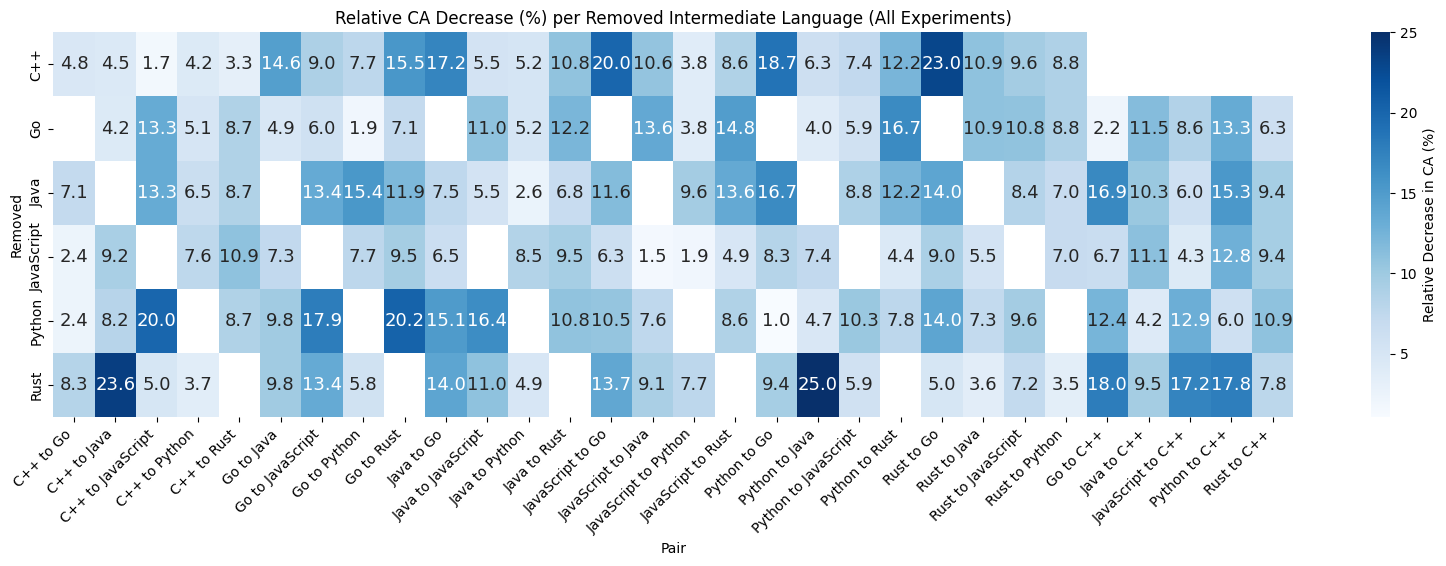

In [70]:
get_ca_heatmap_relative(all_models_heatmap, "Relative CA Decrease (%) per Removed Intermediate Language (All Experiments)")

In [37]:
def get_table_languages_ca_level(data_dict):
    # Extract values and construct the multi-level index
    index_tuples = []
    data_values = []

    for evaluation_type, verify_dict in data_dict.items():
        for model_name, verify_status_dict in verify_dict.items():
            for verify_status, raw_output in verify_status_dict.items():

                #We build a list of the success of a request given the ablations
                df, total_ignored, total_requests = ablation_combination_languages(raw_output)

                grouped = df.groupby(['len_combination'])

                not_ignored = total_requests - total_ignored

                for name, group in grouped:
                    total = group["id_request"].nunique()
                    succ_count = 0

                    #For all the ablation at this level, only count one success
                    for n, g in group.groupby("id_request"):
                        succ_count+=g['success'].sum().any().item()

                    ca = succ_count / total * 100

                    index_tuples.append((evaluation_type, model_name, verify_status))
                    data_values.append([name[0], ca, succ_count, total])

    # Create a multi-index from the tuples
    multi_index = pd.MultiIndex.from_tuples(index_tuples, names=["Evaluation Dataset", "Model Name", "Verify Status"])

    # Create the dataframe
    df_multi = pd.DataFrame(data_values, index=multi_index, columns=["len_removed_langs", "ca", "success", "total"])

    return df_multi

In [38]:
table_ca = get_table_languages_ca_level(data_dict)

In [ ]:
table_ca